# Import

In [1]:
import pandas as pd
import os, torch
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter, MultipleLocator
from exp.plot_config import *

# Setting

In [2]:
from interpret import *
argv = """
--task_name long_term_forecast \
  --explainers feature_ablation \
  --root_path ./dataset/electricity/ \
  --data_path electricity.csv \
  --model DLinear \
  --features S \
  --seq_len 96 \
  --label_len 12 \
  --pred_len 24 \
  --n_features 1 \
  --use_gpu --result_path scratch
""".split()
parser = get_parser()
args = parser.parse_args(argv)
print(args)

setting = stringify_setting(args)

Namespace(task_name='long_term_forecast', train=False, model='DLinear', seed=2021, data='custom', result_path='scratch', root_path='./dataset/electricity/', data_path='electricity.csv', flag='test', features='S', target='OT', freq='h', checkpoints='./checkpoints/', no_scale=False, group_id=None, seq_len=96, label_len=12, pred_len=24, seasonal_patterns='Monthly', top_k=5, num_kernels=6, n_features=1, d_model=128, n_heads=4, e_layers=2, d_layers=1, d_ff=256, moving_avg=25, factor=3, distil=True, dropout=0.1, embed='timeF', activation='gelu', output_attention=False, conv_kernel=None, num_workers=0, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des=None, loss='MSE', lradj='type1', use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', p_hidden_dims=[128, 128], p_hidden_layers=2, disable_progress=False, tsr=False, explainers=['feature_ablation'], areas=[0.05, 0.075, 0.1, 0.15], baseline_mode='random', metrics=['mae', 'mse'], threshold=0, avg_attr_by_

# Attribution

## Load 

In [3]:
# (past_features, know_futures)
explainer_name = args.explainers[0]
attr_output_file = f'{args.flag}_{explainer_name}.pt' 
output_folder = os.path.join(args.result_path, setting)
attr_output_path = os.path.join(output_folder, attr_output_file)

attr = torch.load(attr_output_path)

# attribution of the past features
# attr = attr[0]

In [4]:
attr[0].shape, attr[1].shape

((2607, 24, 96, 1), (2607, 24, 96, 4))

## Global importance

In [5]:
past_feature_importance = attr[0].mean(axis=(0, 1, 2))
time_known_feature_importance = attr[1].mean(axis=(0, 1, 2))
feature_imp = np.concatenate([past_feature_importance, time_known_feature_importance], axis=0)
print(feature_imp)

feature_imp_normalized = feature_imp *100 / (feature_imp.sum())
print(feature_imp_normalized)

[-0.00144567  0.          0.          0.          0.        ]
[100.  -0.  -0.  -0.  -0.]


In [13]:
def normalize(item:np.ndarray, axis=(2,3), l1_norm=False):
    minimum = item.min(axis=axis, keepdims=True)
    maximum = item.max(axis=axis, keepdims=True)
    attr_minmax = (item - minimum)/(maximum-minimum)

    if l1_norm:
        attr_sum = attr_minmax.sum(axis=axis, keepdims=True)
        return attr_minmax / attr_sum 
    else:
        return attr_minmax

## Single Example

In [45]:
importance = np.mean(np.abs(attr[0]), axis=(0))
importance = normalize(importance, axis=(1))

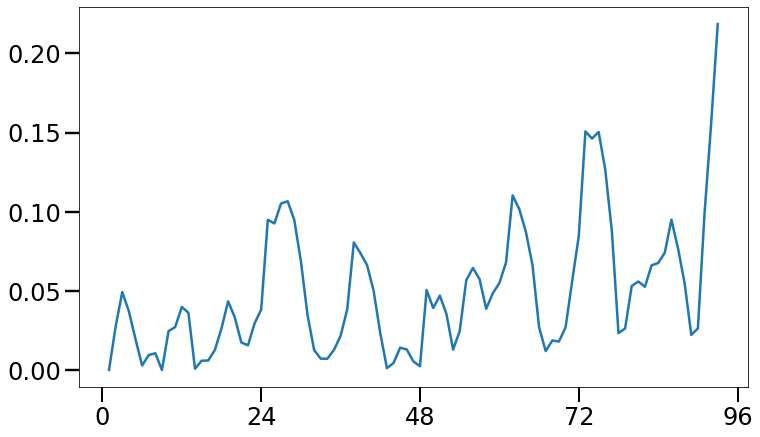

In [55]:
fig, ax = plt.subplots(figsize=(12, 7))
# for i in range(0, importance.shape[0],):
#     ax.plot(range(1, importance.shape[1]+1), importance[i, :, 0], label=f'{i}')
ax.plot(range(1, importance.shape[1]-2), importance[0, :-3, 0])
ax.xaxis.set_major_locator(MultipleLocator(base=24))
# plt.legend(ncol=4)
plt.show()